# Task 1 - Multinomial Logistic Regression

In [1]:
import os
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelBinarizer as LB
from sklearn.metrics import classification_report, accuracy_score

In [2]:
wine_df = pd.read_csv("./Data/WineQT.csv")
wine_df = wine_df.drop(columns=["Id"])
display(wine_df)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1138,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1139,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
1140,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1141,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6


## Task 1.1 - Dataset Analysis and Preprocessing

#### Task 1.1.1 - Attribute-wise dataset metrics

In [3]:
wine_df_values = wine_df.to_numpy()
wine_attributes = wine_df.columns.tolist()
attribute_metrics = pd.DataFrame(columns=wine_attributes[:-1])

attribute_metrics.loc["Mean"]               = np.mean(wine_df_values[:, :-1], axis=0)
attribute_metrics.loc["Standard Deviation"] = np.std( wine_df_values[:, :-1], axis=0)
attribute_metrics.loc["Min Value"]          = np.min( wine_df_values[:, :-1], axis=0)
attribute_metrics.loc["Max Value"]          = np.max( wine_df_values[:, :-1], axis=0)

display(attribute_metrics)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
Mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111
Standard Deviation,1.746830,0.179555,0.196600,1.355324,0.047247,10.246001,32.767787,0.001924,0.156596,0.170324,1.081722
Min Value,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000
Max Value,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000


#### Task 1.1.2 - Label distribution across the dataset

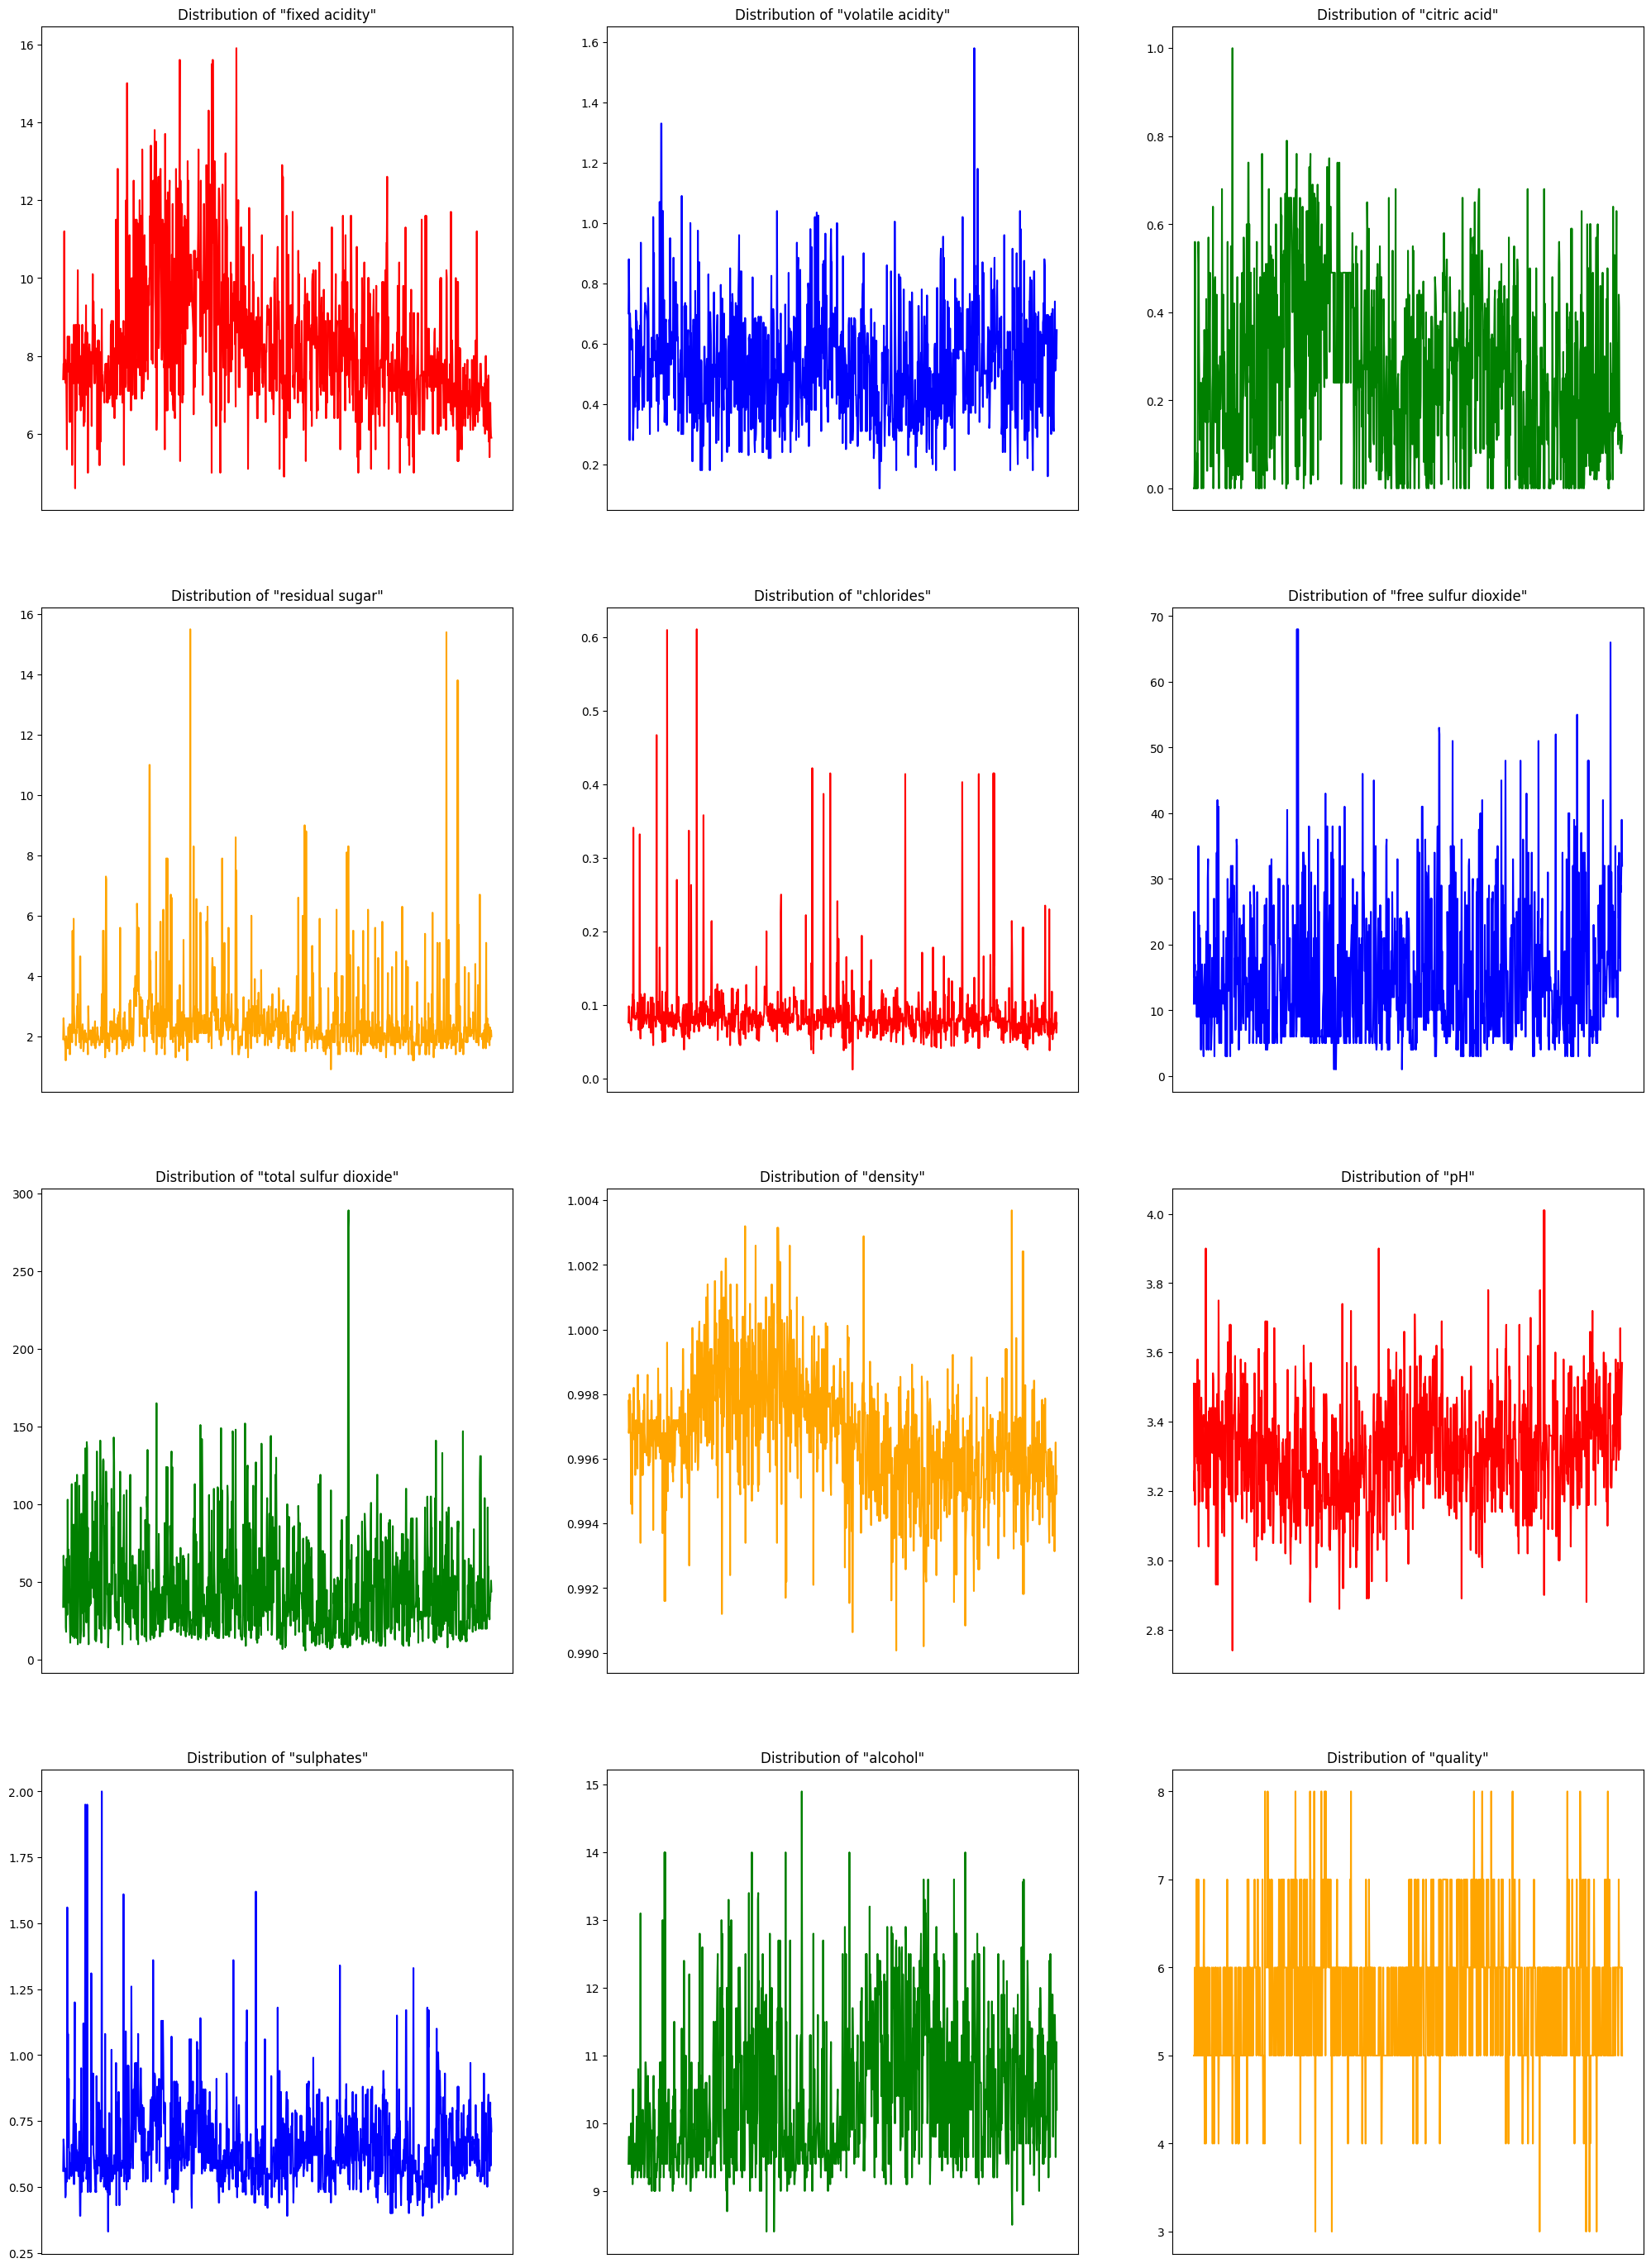

In [4]:
fig, axs = plt.subplots(4, 3, figsize=(25, 35))
colors = np.array(["red", "blue", "green", "orange"])

for i, attribute in enumerate(wine_attributes):
    label_data = wine_df[attribute]
    subplot = axs[int(i / 3), i % 3]
    subplot.plot(range(len(label_data)), label_data, color=colors[i % 4])
    subplot.set_title(f"Distribution of \"{attribute}\"")
    subplot.set_xticklabels([])
    subplot.set_xticks([])

plt.show()

#### Task 1.1.3 - Train-Val-Test split

In [5]:
np.random.seed(0)

wine_df_X, wine_df_Y = wine_df_values[:, :-1], wine_df_values[:, -1]

wine_train_X, wine_val_test_X, wine_train_Y, wine_val_test_Y = train_test_split(wine_df_X, wine_df_Y)
wine_val_X,   wine_test_X,     wine_val_Y,   wine_test_Y     = train_test_split(wine_val_test_X, wine_val_test_Y, train_size=0.6)

#### Task 1.1.4 - Data normalization, standardization, irregular data handling

In [6]:
# Replacing missing values with mean of the respective columns/features
wine_train_X = SimpleImputer().fit_transform(wine_train_X)
wine_val_X   = SimpleImputer().fit_transform(wine_val_X)
wine_test_X  = SimpleImputer().fit_transform(wine_test_X)

# Dataset normalization
wine_train_X = normalize(wine_train_X)
wine_val_X   = normalize(wine_val_X)
wine_test_X  = normalize(wine_test_X)

# Dataset standardization
wine_train_X = StandardScaler().fit_transform(wine_train_X)
wine_val_X   = StandardScaler().fit_transform(wine_val_X)
wine_test_X  = StandardScaler().fit_transform(wine_test_X)

## Task 1.2 - Model Building from Scratch

### Task 1.2.1 - Multinomial Logistic Regression model with Cross Entropy Loss and Gradient Descent

In [7]:
class MultiLogRegression():
    def __init__(self, epochs=10000, lr=0.01):
        self.weights         = None
        self.biases          = None
        self.epochs          = epochs
        self.lr              = lr
        self.one_hot_encoder = None

    def __fit_one_hot(self, y):
        self.one_hot_encoder = LB()
        y_one_hot       = self.one_hot_encoder.fit_transform(y)

        return y_one_hot
    
    def __get_one_hot(self, y):
        return self.one_hot_encoder.transform(y)

    def __softmax(self, X):
        y_pred       = X @ self.weights + self.biases
        y_pred_trunc = y_pred - np.max(y_pred, axis=1)[:, None]         # Subtracting by the max value of the column to prevent blowing up of exponentials

        return np.exp(y_pred_trunc) / np.sum(np.exp(y_pred_trunc), axis=1)[:, None]
    
    def __cross_entropy_loss(self, X, y_one_hot=None):
        return np.sum(-y_one_hot * np.log(self.__softmax(X))) / y_one_hot.shape[0]
    
    def __gradient_descent(self, X, y, y_one_hot):
        for i in range(self.epochs):
            y_pred_probs = self.__softmax(X)
            
            dw = (X.T @ (y_pred_probs - y_one_hot)) / X.shape[0]        # Partial derivative of {x_i * w_c + b_c} wrt w_c gives x_i^T, hence the transpose
            db = np.sum(y_pred_probs - y_one_hot, axis=0) / X.shape[0]
            
            self.weights -= self.lr * dw
            self.biases  -= self.lr * db

            loss     = self.__cross_entropy_loss(X, y_one_hot)
            accuracy = accuracy_score(y, self.predict(X))
            
            if (i + 1) % 1000 == 0:
                print(f"Epoch {i + 1} ----- Loss: {loss} --- Accuracy: {accuracy}")
            
    def fit(self, X, y):
        y_one_hot    = self.__fit_one_hot(y)
        
        self.weights = np.zeros((X.shape[1], y_one_hot.shape[1]))
        self.biases  = np.zeros((1, y_one_hot.shape[1]))

        final_loss = self.__gradient_descent(X, y, y_one_hot)

        return final_loss
    
    def predict(self, X, y=None):
        scores = self.__softmax(X)

        class_indices = np.argmax(scores, axis=1)
        
        if y is None:
            return self.one_hot_encoder.classes_[class_indices]
        
        else:
            y_one_hot = self.__get_one_hot(y)
            return self.one_hot_encoder.classes_[class_indices], self.__cross_entropy_loss(X, y_one_hot)

### Task 1.2.2 - Model training

In [8]:
MLR = MultiLogRegression()
MLR.fit(wine_train_X, wine_train_Y)

Epoch 1000 ----- Loss: 1.1355879498946386 --- Accuracy: 0.5367561260210035
Epoch 2000 ----- Loss: 1.067682148128361 --- Accuracy: 0.558926487747958
Epoch 3000 ----- Loss: 1.0421398855125563 --- Accuracy: 0.5670945157526255
Epoch 4000 ----- Loss: 1.0280100879390521 --- Accuracy: 0.5694282380396732
Epoch 5000 ----- Loss: 1.018638321613865 --- Accuracy: 0.5705950991831972
Epoch 6000 ----- Loss: 1.011729987294509 --- Accuracy: 0.5694282380396732
Epoch 7000 ----- Loss: 1.006277388935519 --- Accuracy: 0.5717619603267211
Epoch 8000 ----- Loss: 1.001769243163361 --- Accuracy: 0.5787631271878646
Epoch 9000 ----- Loss: 0.9979192741620725 --- Accuracy: 0.5822637106184364
Epoch 10000 ----- Loss: 0.9945547794107354 --- Accuracy: 0.588098016336056


### Task 1.2.2 - Classification report on Validation set

In [9]:
pred_validation_labels = MLR.predict(wine_val_X)
validation_report = classification_report(wine_val_Y, pred_validation_labels, zero_division=0)
print("Validation metrics:", end="\n\n")
print(validation_report)

Validation metrics:

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         1
         4.0       0.00      0.00      0.00         5
         5.0       0.64      0.72      0.68        74
         6.0       0.50      0.50      0.50        70
         7.0       0.39      0.35      0.37        20
         8.0       0.00      0.00      0.00         1

    accuracy                           0.56       171
   macro avg       0.25      0.26      0.26       171
weighted avg       0.53      0.56      0.54       171



### Task 1.2.2 - Loss and Accuracy on Train set

In [10]:
pred_train_labels, loss = MLR.predict(wine_train_X, wine_train_Y)
print(f"Loss on train dataset: {loss}")
print(f"Accuracy on train dataset: {accuracy_score(wine_train_Y, pred_train_labels)}")

Loss on train dataset: 0.9945547794107354
Accuracy on train dataset: 0.588098016336056


## Task 1.3 - Hyperparameter Tuning and Evaluation

### Task 1.3.1 - Hyperparameter tuning with W&B logging

In [11]:
##################################################################
###         Commenting out to prevent accidental runs          ###
##################################################################

# os.environ["WANDB_SILENT"] = "true"
# wandb.login()

# project = 'SMAI_MultiLogRegression'
# run_num = 1

# sweep_config = {
#     'method': 'grid',
#     'metric': {'goal': 'maximize', 'name': 'accuracy'},
#     'parameters': {
#         'num_epochs': {'values': [100, 500, 1000, 2000, 5000, 10000, 50000, 100000]},
#         'learning_rates': {'values': [0.1, 0.05, 0.01, 0.005, 0.001]}
#     }
# }

# sweep_id = wandb.sweep(sweep=sweep_config, project=project)
# print()

# def tuning():
#     global run_num

#     run = wandb.init(name=f'Run {run_num}')

#     num_epochs, lr = wandb.config['num_epochs'], wandb.config['learning_rates']
#     print(f"Run {run_num}/40........Epochs:{num_epochs}........Learning rate:{lr}")
    
#     MLR_tuning = MultiLogRegression(epochs=num_epochs, lr=lr)
#     MLR_tuning.fit(wine_train_X, wine_train_Y)

#     wine_val_pred_Y = MLR_tuning.predict(wine_val_X)
#     accuracy = accuracy_score(wine_val_Y, wine_val_pred_Y)

#     wandb.log({'epochs': num_epochs, 'lr': lr, 'accuracy': accuracy})

#     run.finish()
#     run_num += 1

# wandb.agent(sweep_id, tuning)
# wandb.finish()

### Task 1.3.2 - Evaluation of fine-tuned model on test dataset and report creation

In [12]:
num_epochs, lr = best_params = [50000, 0.05]

MLR_test = MultiLogRegression(epochs=num_epochs, lr=lr)
MLR_test.fit(wine_train_X, wine_train_Y)

Epoch 1000 ----- Loss: 1.0186159028918558 --- Accuracy: 0.5705950991831972
Epoch 2000 ----- Loss: 0.9945479186075765 --- Accuracy: 0.588098016336056
Epoch 3000 ----- Loss: 0.9821422063140409 --- Accuracy: 0.5974329054842473
Epoch 4000 ----- Loss: 0.9738972937264528 --- Accuracy: 0.5985997666277713
Epoch 5000 ----- Loss: 0.967967715687756 --- Accuracy: 0.5974329054842473
Epoch 6000 ----- Loss: 0.9635143697450441 --- Accuracy: 0.603267211201867
Epoch 7000 ----- Loss: 0.960061229191445 --- Accuracy: 0.6067677946324388
Epoch 8000 ----- Loss: 0.957312977819009 --- Accuracy: 0.6056009334889149
Epoch 9000 ----- Loss: 0.9550769000481094 --- Accuracy: 0.6056009334889149
Epoch 10000 ----- Loss: 0.9532225254836489 --- Accuracy: 0.6067677946324388
Epoch 11000 ----- Loss: 0.9516588466516627 --- Accuracy: 0.6091015169194866
Epoch 12000 ----- Loss: 0.950320750894748 --- Accuracy: 0.6102683780630105
Epoch 13000 ----- Loss: 0.9491606188372026 --- Accuracy: 0.6102683780630105
Epoch 14000 ----- Loss: 0.9

In [13]:
wine_test_Y_pred = MLR_test.predict(wine_test_X)
report = classification_report(wine_test_Y, wine_test_Y_pred, zero_division=0)
print(report)

              precision    recall  f1-score   support

         4.0       0.00      0.00      0.00         2
         5.0       0.74      0.80      0.77        50
         6.0       0.67      0.71      0.69        48
         7.0       0.56      0.36      0.43        14
         8.0       0.00      0.00      0.00         1

    accuracy                           0.69       115
   macro avg       0.39      0.37      0.38       115
weighted avg       0.67      0.69      0.67       115

